In [1]:
# import modules
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
... # your code here

Ellipsis

In [2]:
# base classes

class Node:
    pass

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

# Density Tree

In [3]:
class DensityTree(Tree):
    def __init__(self):
        super(DensityTree, self).__init__()
        
    def train(self, data, prior, n_min=10):
        '''
        data: the feature matrix for the digit under consideration
        prior: the prior probability of this digit
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        self.prior = prior
        N, D = data.shape
        D_try = int(np.sqrt(D)) # number of features to consider for each split decision

        # find and remember the tree's bounding box, 
        # i.e. the lower and upper limits of the training feature set
        m, M = np.min(data, axis=0), np.max(data, axis=0)
        self.box = m.copy(), M.copy()
        
        # identify invalid features and adjust the bounding box
        # (If m[j] == M[j] for some j, the bounding box has zero volume, 
        #  causing divide-by-zero errors later on. We must exclude these
        #  features from splitting and adjust the bounding box limits 
        #  such that invalid features have no effect on the volume.)
        valid_features   = np.where(m != M)[0]
        invalid_features = np.where(m == M)[0]
        M[invalid_features] = m[invalid_features] + 1

        # initialize the root node
        self.root.data = data
        self.root.box = m.copy(), M.copy()

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min:
                # Call 'make_density_split_node()' with 'D_try' randomly selected 
                # indices from 'valid_features'. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'
                
                #Split two nodes
                left, right = make_density_split_node(node,N,np.random.choice(valid_features, D_try))
                stack.append(left)
                stack.append(right)
            else:
                # Call 'make_density_leaf_node()' to turn 'node' into a leaf node.
                make_density_leaf_node(node, N)# your code here

    def predict(self, x):
        m, M = self.box
        leaf = self.find_leaf(x)
        p = leaf.response*self.prior
        if (np.all(x<=M) and np.all(x>=m)):
            return p
        else:
            return 0
        # return p(x | y) * p(y) if x is within the tree's bounding box 
        # and return 0 otherwise

In [4]:
def make_density_split_node(node, N, feature_indices):
    '''
    node: the node to be split
    N:    the total number of training instances for the current class
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape
    m, M = node.box
    
    #Volume of the Parent Node
    V = np.product(M-m)

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = None, None
    
    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using 
        # 'np.unique()'. Describe here why this is necessary.
        # ANSWER: It is necessary to remove repeated instances in order for thresholds to not cross data points. Otherwise we could end up with children nodes 
        # which either have no data (if inequality is inclusive) or that have the same data in both left and right nodes
        
        data_unique = np.sort(np.unique(node.data[:, j]))
        # Compute candidate thresholds
        tj = (data_unique[1:] + data_unique[:-1])/2.0
        
        
        # Illustration: for loop - hint: vectorized version is possible
        for t in tj:
            #Compute number of instances left and right of threshold t
            Nl = len(data[data[:,j]<t,j]) 
            Nr = len(data[data[:,j]>t,j])
            
            #Compute volume of threshold
            Vl = V*(t-m[j])/(M[j]-m[j])
            Vr = V - Vl
            
            #Compute LOO error for both left and right children and add them
            loo_error = (Nl/(N*Vl))*(Nl/N - 2.0*(Nl-1)/(N-1)) + (Nr/(N*Vr))*(Nr/N - 2.0*(Nr-1)/(N-1))
            
            # choose the best threshold that minimi
            if loo_error < e_min:
                e_min = loo_error
                j_min = j
                t_min = t
                
                
    # create children
    left = Node()
    right = Node()
    
    X = node.data[:,j_min]
    M_left = M.copy()
    m_right = m.copy()
    
    M_left[j_min] = t_min
    m_right[j_min] = t_min
    
    # initialize 'left' and 'right' with the data subsets and bounding boxes
    # according to the optimal split found above
    left.data = node.data[X<t_min,:] # store data in left node -- for subsequent splits
    left.box = m, M_left # store bounding box in left node
    right.data = node.data[X>t_min,:]
    right.box = m_right, M

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right

In [5]:
def make_density_leaf_node(node, N):
    '''
    node: the node to become a leaf
    N:    the total number of training instances for the current class
    '''
    # compute and store leaf response
    m, M = node.box
    n = node.data.shape[0]
    v = np.product(M-m)
    node.response = n/(v*N)

# Decision Tree

In [6]:
class DecisionTree(Tree):
    def __init__(self):
        super(DecisionTree, self).__init__()
        
    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min and not node_is_pure(node):
                #randomly choose D_try features
                feature_indices = np.random.choice(D, D_try, replace=False)
                #split the node into two
                left, right = make_decision_split_node(node, feature_indices)
                #put the two nodes on the stack
                stack.append(left)
                stack.append(right)
            else:
                make_decision_leaf_node(node)
                
    def predict(self, x):
        leaf = self.find_leaf(x)
        return leaf.response

In [7]:
def make_decision_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    # find best feature j (among 'feature_indices') and best threshold t for the split
    #(mainly copied from "density tree")
    e_min = float("inf")
    j_min, t_min = None, None
    for j in feature_indices:
        data_unique = np.sort(np.unique(node.data[:, j]))
        tj = (data_unique[1:] + data_unique[:-1])/2.0
        
        for t in tj:
            data_left = node.data[:, j].copy()
            labels_left = node.labels[data_left<=t].copy()
            data_left = data_left[data_left<=t]
            
            data_right = node.data[:, j].copy()
            labels_right = node.labels[data_right>t].copy()
            data_right = data_right[data_right>t]
            
            #Compute number of instances left and right of threshold t
            Nl = len(data_left)
            Nr = len(data_right)
            
            #compute the number of instances of each class left and right
            classes = np.unique(node.labels)
            Nlk = np.empty(len(classes))
            Nrk = np.empty(len(classes))
            for i, c in enumerate(classes):
                Nlk[i] = len(labels_left[labels_left==c])
                Nrk[i] = len(labels_right[labels_right==c])
            
            #Compute LOO error for both left and right children and add them
            gini = Nl*(1-np.sum(Nlk**2)/Nl**2)+Nr*(1-np.sum(Nrk**2)/Nr**2)
            
            # choose the best threshold that minimizes gini
            if gini < e_min:
                e_min = gini
                j_min = j
                t_min = t
    
    # create children
    left = Node()
    right = Node()
    
    X = node.data[:, j_min]

    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    left.data = node.data[X<=t_min]# data in left node
    left.labels = node.labels[X<=t_min] # corresponding labels
    right.data = node.data[X>t_min]
    right.labels = node.labels[X>t_min]

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right    

In [8]:
def make_decision_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    node.N = len(node.labels)
    node.response = np.sum(1*(node.labels[:, np.newaxis] == np.arange(10)), axis =0)/node.N

In [9]:
def node_is_pure(node):
    '''
    check if 'node' ontains only instances of the same digit
    '''
    return (len(np.unique(node.labels))<=1)

# Evaluation of Density and Decision Tree

In [10]:
# read and prepare the digits data
digits = load_digits()
data = digits["data"]
target = digits["target"]
labels = np.array([0,1,2,3,4,5,6,7,8,9])
# your code here

Density Confusion Matrix


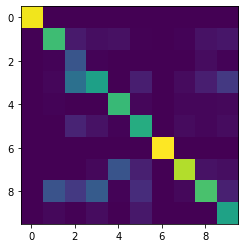

Decision Confusion Matrix


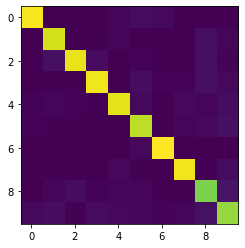

Both Density tree and Decision tree perform rather well, since the diagonal elements of both matrices are in general larger than off diagonal elements. However, it is clear thar decision tree performs much better than density tree, since density tree fails to correctly classify some digits with much more frequency, as  as evinced by some off diagonal elements. Density tree does not classify 8 and 2 digits with as much accuracy as the others. In contrast, Decision tree predicts all  classes with greater accuracy


In [11]:
# train trees, plot training error confusion matrices, and comment on your results
prediction = np.zeros(len(target))
posterior = np.zeros(len(target))
for l in labels:
    Density = DensityTree()
    data_l = data[target == l]
    prior_l = len(data_l)/len(data)
    Density.train(data_l,prior_l)
    for i in range(data.shape[0]):
        x = data[i,:]
        p = Density.predict(x)
        if p>posterior[i]:
            posterior[i] = p
            prediction[i] = l
    
Decision = DecisionTree()
Decision.train(data, target, n_min=20)
prediction_decision = np.zeros(len(target))
for i in range(len(target)):
    x = data[i,:]
    posterior_d = Decision.predict(x)
    prediction_decision[i] = np.argmax(posterior_d)

conf_matrix_dec = np.zeros((len(labels),len(labels)))
conf_matrix_dense = np.zeros((len(labels),len(labels)))

for i in range(10):
    cond = target == i
    conf_matrix_dense[:,i] = np.sum(1*(prediction[cond] == labels[:,np.newaxis]), axis = 1)
    conf_matrix_dec[:,i] = np.sum(1*(prediction_decision[cond] == labels[:,np.newaxis]), axis = 1)
    
plt.figure()
print('Density Confusion Matrix')
plt.imshow(conf_matrix_dense)
plt.show()

print('Decision Confusion Matrix')
plt.figure()
display(plt.imshow(conf_matrix_dec))
plt.show()

print('Both Density tree and Decision tree perform rather well, since the diagonal elements of both matrices are in general larger than off diagonal elements.\
 However, it is clear thar decision tree performs much better than density tree, since density tree fails to correctly classify some digits with much more frequency, as \
 as evinced by some off diagonal elements. Density tree does not classify 8 and 2 digits with as much accuracy as the others. In contrast, Decision tree predicts all \
 classes with greater accuracy')


# Density and Decision Forest

In [12]:
class DensityForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DensityTree() for i in range(n_trees)]
    
    def train(self, data, prior, n_min=20):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            bootstrap_indices = np.random.choice(data.shape[0], data.shape[0])
            bootstrap_data = data[bootstrap_indices,:]
            tree.train(bootstrap_data, prior,n_min)
            
    def predict(self, x):
        #compute average predicted density over all trees
        p = 0
        for tree in self.trees:
            p = p + tree.predict(x)
        return p / len(self.trees)

In [13]:
class DecisionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DecisionTree() for i in range(n_trees)]
    
    def train(self, data, labels, n_min=0):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            bootstrap_indices = np.random.choice(len(labels), len(labels))
            bootstrap_data = data[bootstrap_indices,:]
            bootstrap_labels = target[bootstrap_indices]
            tree.train(bootstrap_data,bootstrap_labels)

    def predict(self, x):
        n_t = len(self.trees)
        predictions = np.zeros(10)
        for tree in self.trees:
            p = tree.predict(x)
            predictions += p/n_t
        return predictions

# Evaluation of Density and Decision Forest

Decision Forest Confusion Matrix


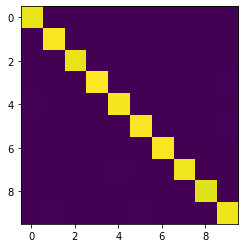

Density Forest Confusion Matrix


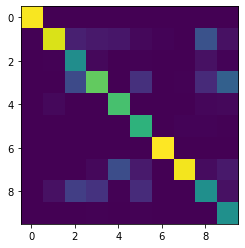

The averaging process from the forest greatly improves the accuracy of the classifiers. Decision Forest has an almost perfect classification,even better than the already outstanding single Decision Tree. Additionally, Density forest has a much less rate of failure than a single density tree. 


In [14]:
# train forests (with 20 trees per forest), plot training error confusion matrices, and comment on your results
n_trees = 20
DecF = DecisionForest(n_trees)
DecF.train(data, target)
prediction_decision = np.zeros(len(target))
prediction_density = np.zeros(len(target))
posterior_density = np.zeros(len(target))
for i in range(data.shape[0]):
    x = data[i,:]
    prediction_decision[i] = np.argmax(DecF.predict(x))

for l in range(10):
    DensityF = DensityForest(n_trees)
    data_l = data[target == l] 
    prior = len(data_l)/len(target)
    DensityF.train(data_l,prior)
    for i in range(data.shape[0]):
        x = data[i,:]
        posterior = DensityF.predict(x)
        if posterior > posterior_density[i]:
            posterior_density[i] = posterior
            prediction_density[i] = l


conf_matrix_dec = np.zeros((len(labels),len(labels)))
conf_matrix_dense = np.zeros((len(labels),len(labels)))
for i in range(10):
    cond = target == i
    conf_matrix_dec[:,i] = np.sum(1*(prediction_decision[cond] == labels[:,np.newaxis]), axis = 1)
    conf_matrix_dense[:,i] = np.sum(1*(prediction_density[cond] == labels[:,np.newaxis]), axis = 1)

plt.figure()
print('Decision Forest Confusion Matrix')
plt.imshow(conf_matrix_dec)
plt.show()

plt.figure()
print('Density Forest Confusion Matrix')
plt.imshow(conf_matrix_dense)
plt.show()

print('The averaging process from the forest greatly improves the accuracy of the classifiers. Decision Forest has an almost perfect classification,\
even better than the already outstanding single Decision Tree. Additionally, Density forest has a much less rate of failure than a single density tree. ')
# your code here